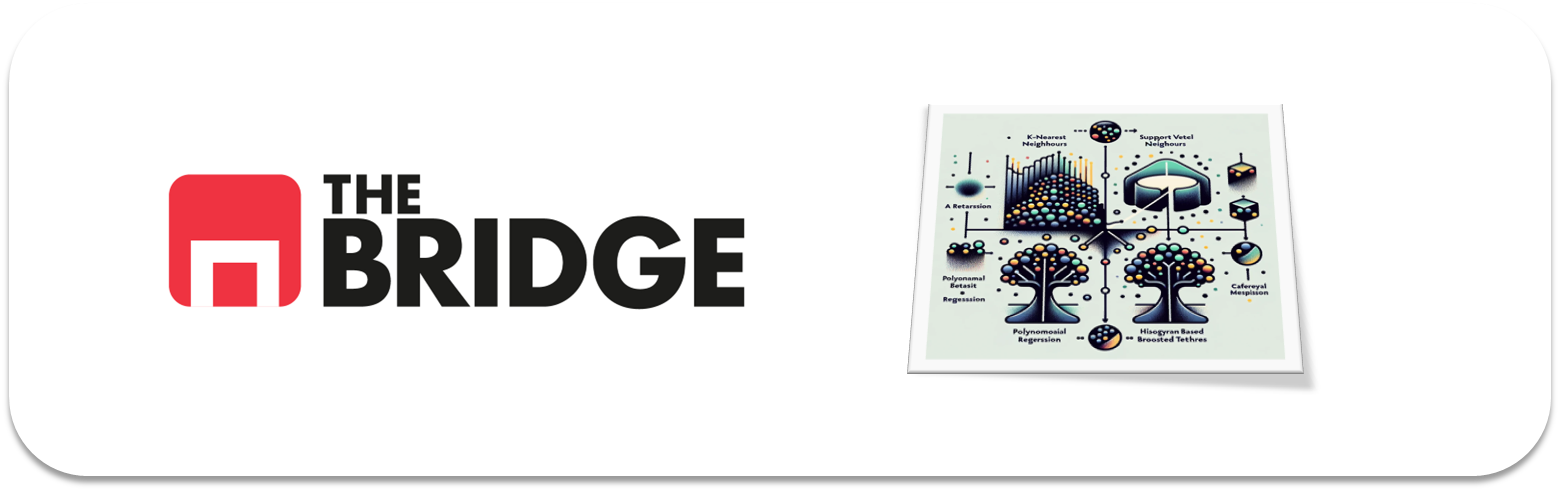

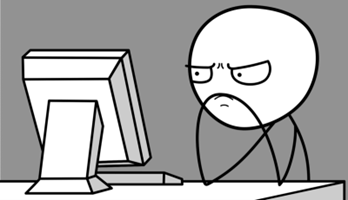

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [61]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import toolbox_ML as tl

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

* Dado que el objetivo es predecir un valor numérico continuo (la concentración de ozono), estamos ante un problema de regresión. Según lo indicado, el ayuntamiento quiere que el modelo se equivoque en media en menos de 100 unidades, lo que implica que el error medio es la preocupación principal.

* Dado que el ayuntamiento necesita un modelo que no se equivoque en más de 100 ppm en media, la métrica más adecuada es el MAE (Mean Absolute Error). Esta métrica mide directamente el error promedio en las mismas unidades que el ozono, lo que permite evaluar de forma clara si el modelo cumple con el umbral exigido. Otras métricas como RMSE o R² pueden complementarse para analizar la calidad global del modelo, pero la principal a optimizar será MAE.

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [4]:
df= pd.read_csv("./data/air_contamination.csv")

In [5]:
df.head(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


* CO(GT):	    Monóxido de carbono en el aire (valor de referencia, Ground Truth)		mg/m³
* PT08.S1(CO)	Señal del sensor PT08.S1, sensible a CO		Unidades del sensor
* NMHC(GT)	Hidrocarburos no metánicos (valor de referencia)		µg/m³
* C6H6(GT)	Benceno (valor de referencia)		µg/m³
* PT08.S2(NMHC)	Señal del sensor PT08.S2, sensible a hidrocarburos no metánicos		Unidades del sensor
* NOx(GT)	Óxidos de nitrógeno (valor de referencia)		µg/m³
* PT08.S3(NOx)	Señal del sensor PT08.S3, sensible a NOx		Unidades del sensor
* NO2(GT)	Dióxido de nitrógeno (valor de referencia)		µg/m³
* PT08.S4(NO2)	Señal del sensor PT08.S4, sensible a NO2		Unidades del sensor
* PT08.S5(O3)	Ozono (valor de referencia, objetivo de predicción)		Unidades del sensor
* T	Temperatura del aire		°C
* RH	Humedad relativa		%
* AH	Humedad absoluta		g/m³ (aprox.)

In [6]:
target = "PT08.S5(O3)"

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       8991 non-null   int64  
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        8991 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        8991 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 913.3 KB


In [8]:
df.nunique()

CO(GT)             95
PT08.S1(CO)      3245
NMHC(GT)          428
C6H6(GT)         3772
PT08.S2(NMHC)    3772
NOx(GT)          2362
PT08.S3(NOx)     3518
NO2(GT)          1367
PT08.S4(NO2)     4407
PT08.S5(O3)      4678
T                3367
RH               4902
AH               8987
dtype: int64

In [9]:
df.isna().sum()

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),8991.0,-34.897053,78.202259,-200.000000,0.600000,1.500000,2.600000,11.900000
PT08.S1(CO),8991.0,1099.707856,217.084571,647.250000,936.750000,1063.000000,1231.250000,2039.750000
NMHC(GT),8991.0,-158.702591,140.680200,-200.000000,-200.000000,-200.000000,-200.000000,1189.000000
C6H6(GT),8991.0,10.082993,7.449640,0.149048,4.436942,8.239851,13.988478,63.741476
PT08.S2(NMHC),8991.0,939.029205,266.829000,383.250000,734.375000,909.000000,1116.250000,2214.000000
NOx(GT),8991.0,163.732788,252.081877,-200.000000,49.000000,139.800000,280.000000,1479.000000
PT08.S3(NOx),8991.0,835.370973,256.815106,322.000000,657.875000,805.500000,969.250000,2682.750000
NO2(GT),8991.0,56.654087,126.902274,-200.000000,52.000000,96.000000,132.000000,332.600000
PT08.S4(NO2),8991.0,1456.143486,346.204540,551.000000,1226.625000,1462.750000,1673.500000,2775.000000
PT08.S5(O3),8991.0,1022.780725,398.480897,221.000000,731.375000,963.250000,1273.375000,2522.750000


### Ejercicio 3: Split

Haz el split en train y test.

In [11]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

<Axes: xlabel='PT08.S5(O3)', ylabel='Count'>

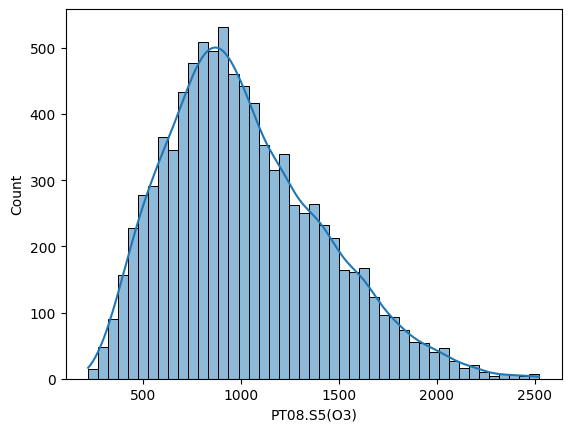

In [14]:
sns.histplot(x =target, data= df, kde= True)

*La distribución tiene cierta "normalidad" que es buena para la regresión lineal, aunque no vayamos a utilizar ese modelo, en general "nos gusta" que tenga esa distribución*

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [15]:
tl.tipifica_variables(df,umbral_categoria=10, umbral_continua=0.2)

,nombre_variable,tipo_sugerido
0,CO(GT),Numerica Discreta
1,PT08.S1(CO),Numerica Continua
2,NMHC(GT),Numerica Discreta
3,C6H6(GT),Numerica Continua
4,PT08.S2(NMHC),Numerica Continua
5,NOx(GT),Numerica Continua
6,PT08.S3(NOx),Numerica Continua
7,NO2(GT),Numerica Discreta
8,PT08.S4(NO2),Numerica Continua
9,PT08.S5(O3),Numerica Continua


In [18]:
np.abs(train_set.corr(numeric_only=True)[target]).sort_values(ascending=False)

PT08.S5(O3)      1.000000
PT08.S1(CO)      0.901005
PT08.S2(NMHC)    0.879959
C6H6(GT)         0.864269
PT08.S3(NOx)     0.794185
NOx(GT)          0.623100
PT08.S4(NO2)     0.590688
NO2(GT)          0.337581
RH               0.133955
CO(GT)           0.128110
NMHC(GT)         0.110077
AH               0.069113
T                0.032899
Name: PT08.S5(O3), dtype: float64

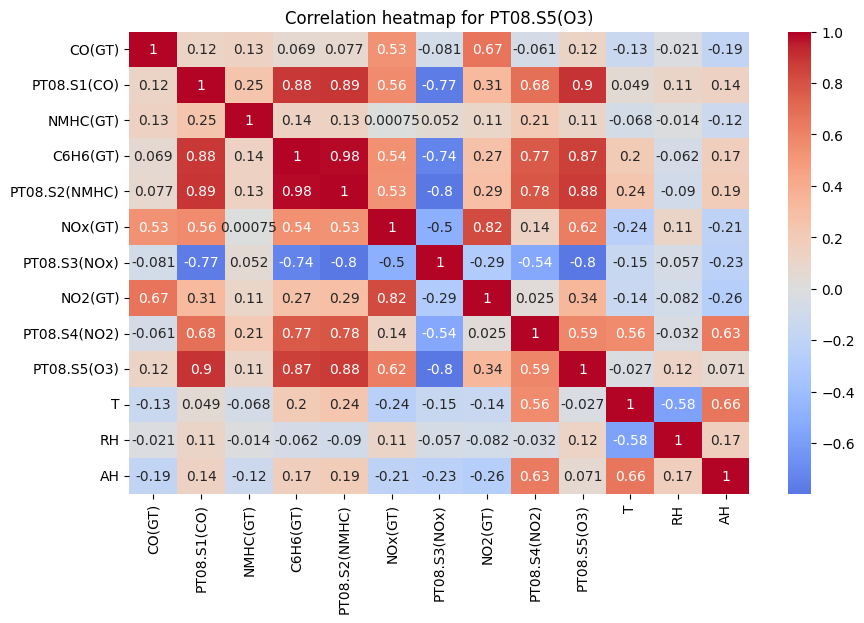

['PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)']

In [21]:
tl.get_features_num_regression(df,target_col= target,umbral_corr=0.2,pvalue=0.5,mostrar=True)

* El conjunto de datos presenta variables altamente correlacionadas entre sí, especialmente entre sensores que miden contaminantes similares. Por ejemplo, PT08.S2(NMHC) muestra una fuerte correlación tanto con C6H6(GT) como con PT08.S4(NO2). Esta multicolinealidad puede afectar negativamente a algunos modelos (como la regresión lineal), por lo que podría ser conveniente aplicar técnicas de reducción de dimensionalidad (como PCA) o eliminar variables redundantes para mejorar la interpretabilidad y el rendimiento del modelo."

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [22]:
features_num = ['PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)']

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

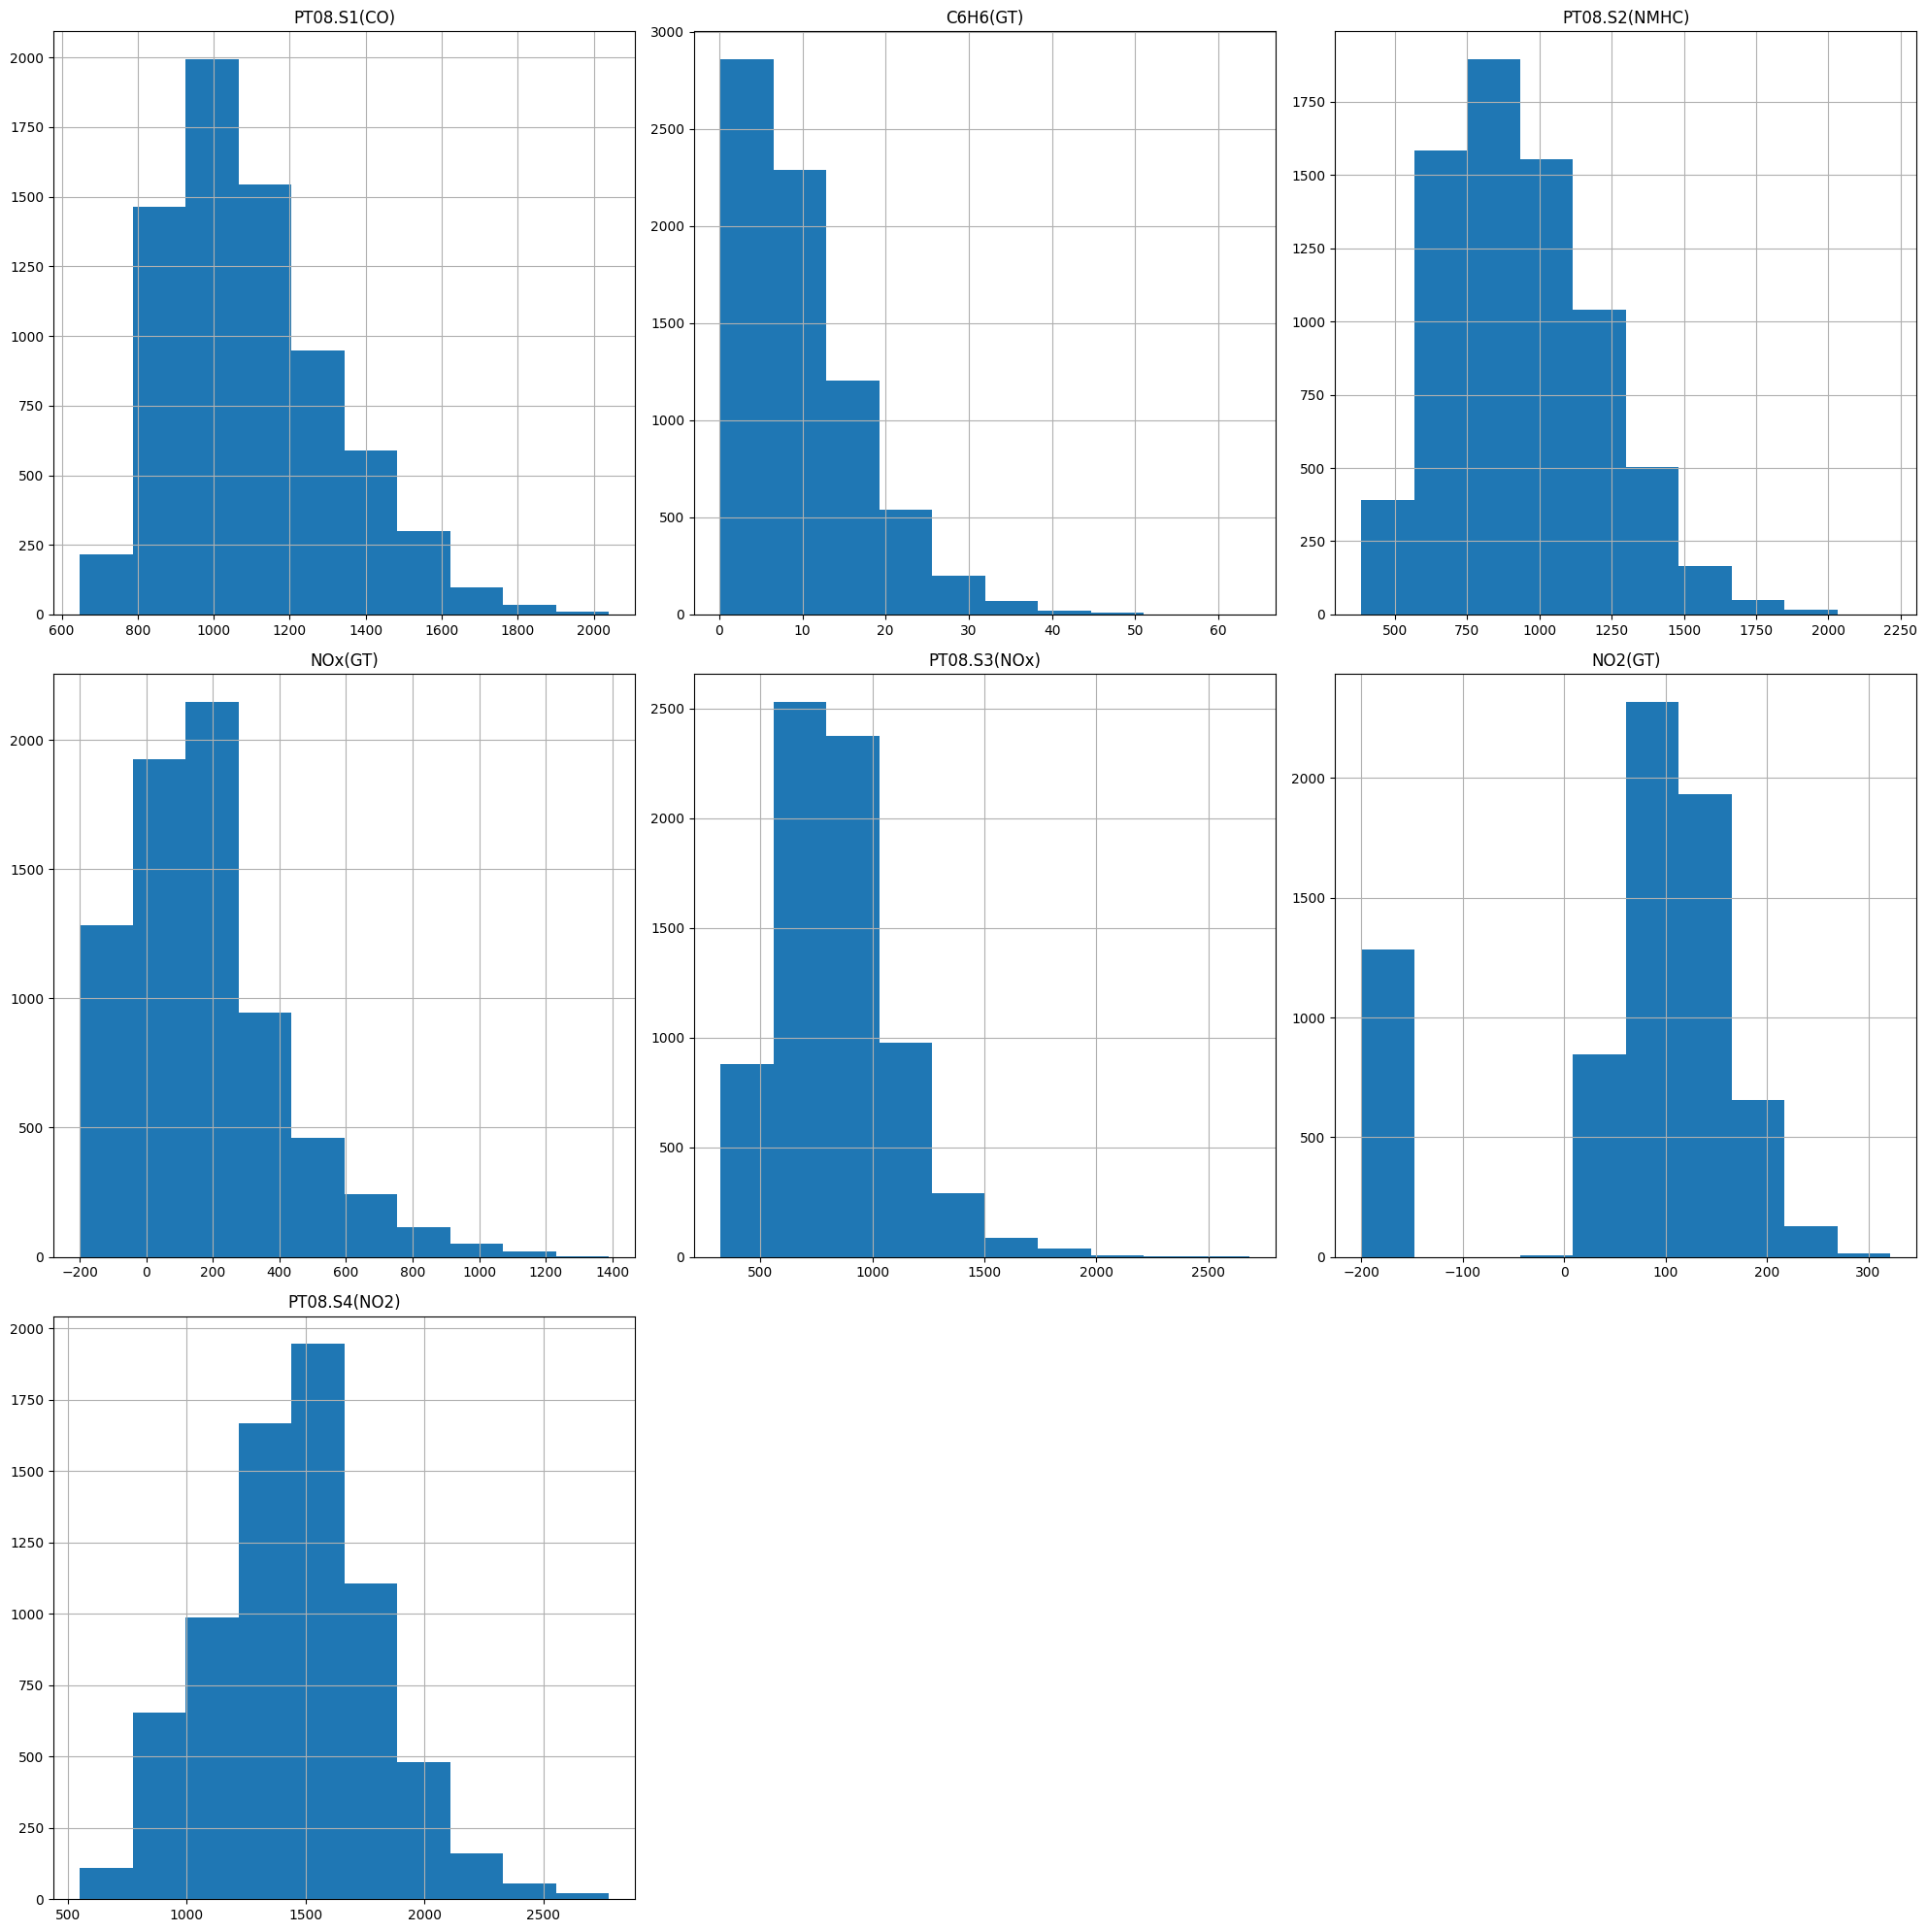

In [23]:
train_set[features_num].hist(figsize = (20,20))
plt.tight_layout()

No es necesario escalar para los modelos que seleccionamos ya que  nos vamos a centrar en los regresores basados en ensamblados de árboles (random forest, Xgboost, etc), así que no necesitaremos escalar nuestras features, ya que los árboles en los que se basan no son sensibles a las escalas de las variables*

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [59]:
X_train = train_set[features_num]
y_train = train_set["PT08.S5(O3)"]

In [60]:
X_test= test_set[features_num]
y_test = test_set["PT08.S5(O3)"]

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [31]:
rf_reg= RandomForestRegressor(max_depth = 10,random_state=42)
xgb_reg= XGBRegressor(max_depth = 10,random_state=42)
lgb_reg = LGBMRegressor(max_depth = 10,random_state= 42, verbose = -100)

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [39]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [40]:
rf_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [46]:
print(np.mean(cross_val_score(rf_reg, X_train, y_train, cv = 5, scoring = "neg_mean_absolute_error")))

-96.2963554614307


In [47]:
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [48]:
print(np.mean(cross_val_score(xgb_reg, X_train, y_train, cv = 5, scoring = "neg_mean_absolute_error")))

-97.0401141402439


In [49]:
lgb_reg.fit(X_train,y_train)

LGBMRegressor(max_depth=10, random_state=42, verbose=-100)

In [50]:
print(np.mean(cross_val_score(lgb_reg, X_train, y_train, cv = 5, scoring = "neg_mean_absolute_error")))

-96.26086551204324


### Nos quedamos con el Random forest ya que es mas sencillo

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(
    rf_reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [57]:
print("Mejor MAE:", -rf_grid.best_score_)

Mejor MAE: 93.27849608547794


In [58]:
print("Mejores parámetros:", rf_grid.best_params_)

Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [62]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 90.85472090976474
MAPE: 0.09826363564608252
RMSE: 122.50718303221943


Conclusión clave: El modelo cumple con el objetivo del Ayuntamiento de mantener un error medio por debajo de 100 ppm, siendo por tanto adecuado para su uso operativo en la plataforma de predicción de calidad del aire.

Este sistema permitirá detectar de forma temprana niveles elevados de ozono, mejorando la capacidad de respuesta ante situaciones de riesgo para la salud pública.

### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

In [63]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

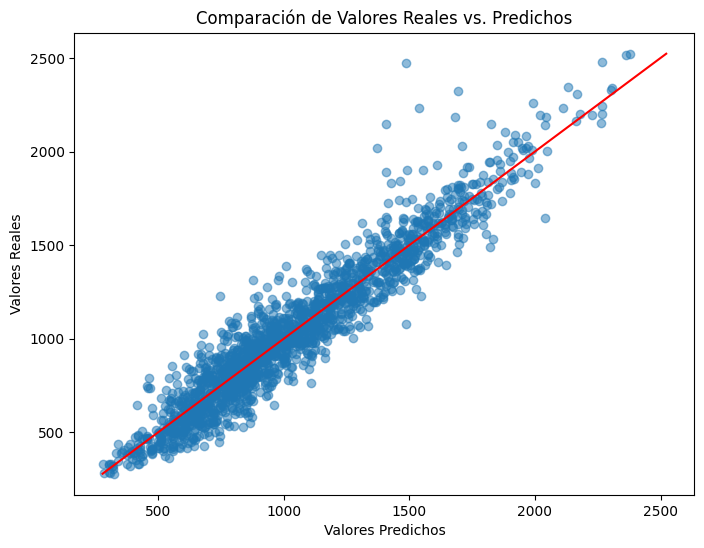

In [64]:
plot_predictions_vs_actual(y_test, y_pred)

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.